# SOM - CESM Member 001

#### Template from 'Basic uses of SOMPY library', modified for our use
http://www.vahidmoosavi.com

https://github.com/sevamoo/sompy

In [110]:
import matplotlib.pylab as plt
%matplotlib inline
# import sompy as sompy
import pandas as pd
import numpy as np
from time import time
import sompy

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

import os
import xarray as xr

import datetime

In [44]:
import math
import glob
import matplotlib
import matplotlib.pyplot as plt
from sklearn.externals import joblib
import random

from sompy.sompy import SOMFactory
from sompy.visualization.plot_tools import plot_hex_map
import logging

import random

In [114]:
os.getcwd()

'C:\\Users\\goyetc\\SOMPY'

#### Prepare Data for Model
* Import data, view basic characteristics
* normalize
* Observe 2d abstraction of SOM results
* Extract cluster designations








In [2]:
DATA_DIR = 'C:\\Users\\goyetc\\ocean-co2-absorption\\data'
#DATA_DIR = '/Users/cg/co2/'
dataset_names = {'pCO2': 'pCO2_2D_mon_CESM001_1x1_198201-201701.nc',
                 'XCO2': 'XCO2_1D_mon_CESM001_native_198201-201701.nc',
                 'SST': 'SST_2D_mon_CESM001_1x1_198201-201701.nc',
                 'SSS': 'SSS_2D_mon_CESM001_1x1_198201-201701.nc',
                 'MLD': 'MLD_2D_mon_CESM001_1x1_198201-201701.nc',
                 'Chl': 'Chl_2D_mon_CESM001_1x1_198201-201701.nc'}
ds = {}
for dataset in dataset_names.keys():
    filename = os.path.join(DATA_DIR, dataset_names[dataset])
    ds[dataset] = xr.open_dataset(filename)

In [3]:
df = {}
for dataset in ds.keys():
    # e.g. pCO2
    df[dataset] = ds[dataset][dataset].to_dataframe()
    
    #note np.isfinite eliminates infinite and/or NaN records from dataset 
    df[dataset] = df[dataset][np.isfinite(df[dataset][dataset])].reset_index()


In [4]:
SOM_input = pd.concat([df['SSS'],df['MLD']['MLD'],df['SST']['SST'],df['pCO2']['pCO2']], axis=1)

In [5]:
SOM_input.head()

,time,ylat,xlon,SSS,MLD,SST,pCO2
0,1982-01-16 12:00:00,-77.5,179.5,34.000992,16.192860,1.648732,151.525853
1,1982-01-16 12:00:00,-77.5,180.5,33.941429,15.115437,1.528921,150.330599
2,1982-01-16 12:00:00,-77.5,181.5,33.863464,14.071844,1.350243,148.500409
3,1982-01-16 12:00:00,-77.5,182.5,33.775764,13.072312,1.119088,146.198458
4,1982-01-16 12:00:00,-77.5,183.5,33.691376,12.333377,0.865820,143.769723


In [6]:
#Filter out outliers, SSS
SOM_input = SOM_input.loc[SOM_input['SSS'] > 8]

### Note above: 15k outliers from SSS removed, see scatterplots
* Could further constrain data to improve model parameters, but 'lost' data may have more information we don't want to omit

In [10]:
for i in range(12):
    print i+1

1
2
3
4
5
6
7
8
9
10
11
12


In [30]:
SOM_input.set_index(pd.DatetimeIndex(SOM_input['time']))
SOM_input['month'] = pd.DatetimeIndex(SOM_input['time']).month
Monthly = {}
for i in range(12):
    Monthly['month-'+str(i+1)] = SOM_input.loc[SOM_input['month'] == (i+1)]

In [24]:
Monthly.keys()

['month-10',
 'month-11',
 'month-12',
 'month-8',
 'month-9',
 'month-6',
 'month-7',
 'month-4',
 'month-5',
 'month-2',
 'month-3',
 'month-1']

In [36]:
for i in range(12):
    Monthly['month-'+str(i+1)] = Monthly['month-'+str(i+1)].drop(columns='month').sample(frac=1).reset_index(drop=True)
    Monthly['month-'+str(i+1)] = Monthly['month-'+str(i+1)].groupby(['ylat','xlon'], as_index=False).mean()

In [105]:
for i in range(12):
    Monthly['month-'+str(i+1)]['log_MLD'] = Monthly['month-'+str(i+1)]['MLD'].apply(np.log)

In [106]:
Monthly['month-1'].head(), Monthly['month-1'].shape

(   ylat   xlon        SSS        MLD       SST        pCO2  k=5  k=10  k=15  \
 0 -77.5  179.5  33.877541  15.948417  1.349778  155.399963    2     6    10   
 1 -77.5  180.5  33.831253  15.072249  1.214095  153.832620    2     6    10   
 2 -77.5  181.5  33.773590  14.233934  1.035777  151.635294    2     6    10   
 3 -77.5  182.5  33.712555  13.452983  0.825134  149.043507    2     6    10   
 4 -77.5  183.5  33.657063  12.789043  0.598411  146.350144    2     6    10   
 
     log_MLD  
 0  2.769360  
 1  2.712855  
 2  2.655629  
 3  2.599201  
 4  2.548589  , (41035, 10))

# Scale Data

#### choice of normalization or transform? 
* would like to try sample runs both ways and evaluate performance 

In [134]:
#Prepare data

#log(MLD)
#means[['MLD']] = means[['MLD']].apply(np.log)

#scale
ss = StandardScaler().fit_transform(means[['SSS','SST','MLD','pCO2']])

In [41]:
#for i in range(12):
ss = StandardScaler().fit_transform(Monthly['month-'+str(i+1)][['SSS','SST','MLD','pCO2']])


C:\Users\goyetc\AppData\Local\Continuum\anaconda3\envs\sompy_env\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\goyetc\AppData\Local\Continuum\anaconda3\envs\sompy_env\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [42]:
#tuning parameters
#research suggests M = 5*sqrt(N) is a good choice for number of neurons
M = 5*np.sqrt(ss.shape[0])
M
#insert source

1012.8548760804778

In [43]:
m=int(np.sqrt(M))
m

31

### Notes on SOM tuning
* testing suggests pca is faster than random init but limits # of epochs/trainlen internal to SOM engine
* batch faster than sequential

### From Original SOMtoolbox documentation
* http://www.cis.hut.fi/somtoolbox/package/docs2/som_quality.html

*     qe : Average distance between each data vector and its BMU.
       Measures map resolution.
*     te : Topographic error, the proportion of all data vectors
       for which first and second BMUs are not adjacent units.
       Measures topology preservation.

#### Model 0 has the lowest topographic error so we will use these hyperparameters moving forward
* map size = [29,35]
* rectangular mapping
* pca initialization

In [162]:
mean_best.calculate_map_size('rect')


[29, 35]

In [169]:
mean_best.__dict__

{'_bmu': array([[  5.62000000e+02,   5.62000000e+02,   5.62000000e+02, ...,
           2.30000000e+01,   2.30000000e+01,   2.30000000e+01],
        [  1.79329921e+00,   1.80683533e+00,   1.81591119e+00, ...,
           1.35550033e-02,   1.41659069e-02,   1.47852844e-02]]),
 '_component_names': [['SSS', 'SST', 'MLD', 'pCO2']],
 '_data': array([[ 0.18913603, -1.3459917 ,  3.41670057, -2.6790296 ],
        [ 0.17588447, -1.3475531 ,  3.41021886, -2.69762985],
        [ 0.15916678, -1.34988534,  3.38340523, -2.72281208],
        ..., 
        [-0.84256275, -1.39285668, -0.15187448, -1.19543379],
        [-0.84284339, -1.39285576, -0.15225229, -1.19487994],
        [-0.84312895, -1.39285485, -0.15263131, -1.19433144]]),
 '_dim': 4L,
 '_distance_matrix': array([[  0.00000000e+00,   1.00000000e+00,   4.00000000e+00, ...,
           1.19060000e+04,   1.21250000e+04,   1.23460000e+04],
        [  1.00000000e+00,   0.00000000e+00,   1.00000000e+00, ...,
           1.16890000e+04,   1.19060000e+0

In [163]:
mean_best.calculate_topographic_error()

0.10807846959912271

In [164]:
mean_best.calculate_quantization_error()

0.10945089303776113

## Observe effects of various training lengths on best model from above
* Note: first pass, same performance was not achieved as the randomly achieved best performance as before. Nevertheless, decent topographical perf and and quant perf achieved
* Also note below that various training times do not significantly improve topographical error, and quantization error is basically flat. Implies we can achieve reasonable mapping with low(ish) epochs of rough/fine tuning

In [179]:
map_best = mean_best.calculate_map_size('rect')
names = ['SSS','SST','MLD','pCO2']

for i in range(20): 
    
    
    sm = sompy.SOMFactory().build(ss, mapsize = map_best, mapshape = 'planar',
                            initialization='pca',
                            normalization = None, 
                            component_names=names, lattice='rect') 
    sm.train(n_job=4, 
             verbose='info', 
             train_rough_len=random.choice(list(range(20,40))),
             train_finetune_len=random.choice(list(range(40,100))),
             #train_rough_radiusin=14,
             #train_rough_radiusfin=3.5,
             #train_finetune_radiusin=3.5,
             #train_finetune_radiusfin=1
            ) 
    
    joblib.dump(sm, "model_mean_opt_r3_epochs_{}.joblib".format(i))

 Training...
 pca_linear_initialization took: 0.054000 seconds
 Rough training...
 radius_ini: 5.000000 , radius_final: 1.250000, trainlen: 32

 epoch: 1 ---> elapsed time:  0.387000, quantization error: 0.895949

 epoch: 2 ---> elapsed time:  0.390000, quantization error: 0.708758

 epoch: 3 ---> elapsed time:  0.397000, quantization error: 0.654553

 epoch: 4 ---> elapsed time:  0.390000, quantization error: 0.631314

 epoch: 5 ---> elapsed time:  0.391000, quantization error: 0.614198

 epoch: 6 ---> elapsed time:  0.396000, quantization error: 0.601104

 epoch: 7 ---> elapsed time:  0.387000, quantization error: 0.589545

 epoch: 8 ---> elapsed time:  0.387000, quantization error: 0.578247

 epoch: 9 ---> elapsed time:  0.387000, quantization error: 0.567044

 epoch: 10 ---> elapsed time:  0.387000, quantization error: 0.555391

 epoch: 11 ---> elapsed time:  0.388000, quantization error: 0.543574

 epoch: 12 ---> elapsed time:  0.388000, quantization error: 0.531560

 epoch: 13 --

 epoch: 82 ---> elapsed time:  0.389000, quantization error: 0.221726

 epoch: 83 ---> elapsed time:  0.392000, quantization error: 0.221453

 epoch: 84 ---> elapsed time:  0.396000, quantization error: 0.221170

 epoch: 85 ---> elapsed time:  0.402000, quantization error: 0.220880

 epoch: 86 ---> elapsed time:  0.391000, quantization error: 0.220592

 epoch: 87 ---> elapsed time:  0.398000, quantization error: 0.220300

 epoch: 88 ---> elapsed time:  0.391000, quantization error: 0.219984

 epoch: 89 ---> elapsed time:  0.390000, quantization error: 0.219694

 epoch: 90 ---> elapsed time:  0.390000, quantization error: 0.219369

 Final quantization error: 0.219369
 train took: 51.657000 seconds
 Training...
 pca_linear_initialization took: 0.060000 seconds
 Rough training...
 radius_ini: 5.000000 , radius_final: 1.250000, trainlen: 35

 epoch: 1 ---> elapsed time:  0.387000, quantization error: 0.895949

 epoch: 2 ---> elapsed time:  0.393000, quantization error: 0.708758

 epoch: 3 

 epoch: 69 ---> elapsed time:  0.394000, quantization error: 0.224983

 epoch: 70 ---> elapsed time:  0.395000, quantization error: 0.224653

 epoch: 71 ---> elapsed time:  0.395000, quantization error: 0.224329

 epoch: 72 ---> elapsed time:  0.394000, quantization error: 0.224020

 epoch: 73 ---> elapsed time:  0.386000, quantization error: 0.223703

 epoch: 74 ---> elapsed time:  0.396000, quantization error: 0.223383

 epoch: 75 ---> elapsed time:  0.395000, quantization error: 0.223073

 epoch: 76 ---> elapsed time:  0.394000, quantization error: 0.222682

 epoch: 77 ---> elapsed time:  0.395000, quantization error: 0.222333

 epoch: 78 ---> elapsed time:  0.394000, quantization error: 0.222017

 epoch: 79 ---> elapsed time:  0.397000, quantization error: 0.221696

 epoch: 80 ---> elapsed time:  0.403000, quantization error: 0.221374

 epoch: 81 ---> elapsed time:  0.395000, quantization error: 0.221073

 epoch: 82 ---> elapsed time:  0.394000, quantization error: 0.220774

 epoch

 epoch: 60 ---> elapsed time:  0.393000, quantization error: 0.222064

 epoch: 61 ---> elapsed time:  0.394000, quantization error: 0.221645

 epoch: 62 ---> elapsed time:  0.394000, quantization error: 0.221228

 epoch: 63 ---> elapsed time:  0.393000, quantization error: 0.220825

 epoch: 64 ---> elapsed time:  0.394000, quantization error: 0.220415

 Final quantization error: 0.220415
 train took: 41.051000 seconds
 Training...
 pca_linear_initialization took: 0.071000 seconds
 Rough training...
 radius_ini: 5.000000 , radius_final: 1.250000, trainlen: 30

 epoch: 1 ---> elapsed time:  0.395000, quantization error: 0.895949

 epoch: 2 ---> elapsed time:  0.394000, quantization error: 0.708758

 epoch: 3 ---> elapsed time:  0.496000, quantization error: 0.653962

 epoch: 4 ---> elapsed time:  0.399000, quantization error: 0.630058

 epoch: 5 ---> elapsed time:  0.395000, quantization error: 0.612299

 epoch: 6 ---> elapsed time:  0.395000, quantization error: 0.598563

 epoch: 7 --->

 Rough training...
 radius_ini: 5.000000 , radius_final: 1.250000, trainlen: 36

 epoch: 1 ---> elapsed time:  0.390000, quantization error: 0.895949

 epoch: 2 ---> elapsed time:  0.394000, quantization error: 0.708758

 epoch: 3 ---> elapsed time:  0.400000, quantization error: 0.655532

 epoch: 4 ---> elapsed time:  0.506000, quantization error: 0.633385

 epoch: 5 ---> elapsed time:  0.407000, quantization error: 0.617296

 epoch: 6 ---> elapsed time:  0.398000, quantization error: 0.605288

 epoch: 7 ---> elapsed time:  0.393000, quantization error: 0.594954

 epoch: 8 ---> elapsed time:  0.394000, quantization error: 0.585000

 epoch: 9 ---> elapsed time:  0.394000, quantization error: 0.575062

 epoch: 10 ---> elapsed time:  0.394000, quantization error: 0.565104

 epoch: 11 ---> elapsed time:  0.394000, quantization error: 0.554767

 epoch: 12 ---> elapsed time:  0.393000, quantization error: 0.544426

 epoch: 13 ---> elapsed time:  0.393000, quantization error: 0.533683

 epoc

 epoch: 15 ---> elapsed time:  0.394000, quantization error: 0.497443

 epoch: 16 ---> elapsed time:  0.492000, quantization error: 0.483338

 epoch: 17 ---> elapsed time:  0.394000, quantization error: 0.469777

 epoch: 18 ---> elapsed time:  0.394000, quantization error: 0.457810

 epoch: 19 ---> elapsed time:  0.415000, quantization error: 0.445791

 epoch: 20 ---> elapsed time:  0.400000, quantization error: 0.433663

 epoch: 21 ---> elapsed time:  0.502000, quantization error: 0.421378

 epoch: 22 ---> elapsed time:  0.393000, quantization error: 0.408959

 epoch: 23 ---> elapsed time:  0.402000, quantization error: 0.396386

 epoch: 24 ---> elapsed time:  0.394000, quantization error: 0.383763

 epoch: 25 ---> elapsed time:  0.393000, quantization error: 0.371039

 epoch: 26 ---> elapsed time:  0.394000, quantization error: 0.358279

 epoch: 27 ---> elapsed time:  0.393000, quantization error: 0.345440

 epoch: 28 ---> elapsed time:  0.393000, quantization error: 0.332546

 epoch

 epoch: 6 ---> elapsed time:  0.395000, quantization error: 0.602259

 epoch: 7 ---> elapsed time:  0.395000, quantization error: 0.591004

 epoch: 8 ---> elapsed time:  0.396000, quantization error: 0.580081

 epoch: 9 ---> elapsed time:  0.393000, quantization error: 0.569208

 epoch: 10 ---> elapsed time:  0.397000, quantization error: 0.558059

 epoch: 11 ---> elapsed time:  0.402000, quantization error: 0.546622

 epoch: 12 ---> elapsed time:  0.394000, quantization error: 0.535077

 epoch: 13 ---> elapsed time:  0.400000, quantization error: 0.523051

 epoch: 14 ---> elapsed time:  0.391000, quantization error: 0.510671

 epoch: 15 ---> elapsed time:  0.399000, quantization error: 0.497443

 epoch: 16 ---> elapsed time:  0.395000, quantization error: 0.483338

 epoch: 17 ---> elapsed time:  0.399000, quantization error: 0.469777

 epoch: 18 ---> elapsed time:  0.401000, quantization error: 0.457810

 epoch: 19 ---> elapsed time:  0.396000, quantization error: 0.445791

 epoch: 20

 epoch: 5 ---> elapsed time:  0.401000, quantization error: 0.615039

 epoch: 6 ---> elapsed time:  0.398000, quantization error: 0.602259

 epoch: 7 ---> elapsed time:  0.394000, quantization error: 0.591004

 epoch: 8 ---> elapsed time:  0.393000, quantization error: 0.580081

 epoch: 9 ---> elapsed time:  0.392000, quantization error: 0.569208

 epoch: 10 ---> elapsed time:  0.393000, quantization error: 0.558059

 epoch: 11 ---> elapsed time:  0.394000, quantization error: 0.546622

 epoch: 12 ---> elapsed time:  0.397000, quantization error: 0.535077

 epoch: 13 ---> elapsed time:  0.392000, quantization error: 0.523051

 epoch: 14 ---> elapsed time:  0.394000, quantization error: 0.510671

 epoch: 15 ---> elapsed time:  0.390000, quantization error: 0.497443

 epoch: 16 ---> elapsed time:  0.396000, quantization error: 0.483338

 epoch: 17 ---> elapsed time:  0.392000, quantization error: 0.469777

 epoch: 18 ---> elapsed time:  0.394000, quantization error: 0.457810

 epoch: 19 

 epoch: 5 ---> elapsed time:  0.397000, quantization error: 0.596560

 epoch: 6 ---> elapsed time:  0.397000, quantization error: 0.576985

 epoch: 7 ---> elapsed time:  0.396000, quantization error: 0.558249

 epoch: 8 ---> elapsed time:  0.395000, quantization error: 0.539270

 epoch: 9 ---> elapsed time:  0.394000, quantization error: 0.519083

 epoch: 10 ---> elapsed time:  0.393000, quantization error: 0.498257

 epoch: 11 ---> elapsed time:  0.394000, quantization error: 0.477052

 epoch: 12 ---> elapsed time:  0.394000, quantization error: 0.455629

 epoch: 13 ---> elapsed time:  0.393000, quantization error: 0.433599

 epoch: 14 ---> elapsed time:  0.396000, quantization error: 0.411449

 epoch: 15 ---> elapsed time:  0.396000, quantization error: 0.389228

 epoch: 16 ---> elapsed time:  0.393000, quantization error: 0.366803

 epoch: 17 ---> elapsed time:  0.394000, quantization error: 0.344548

 epoch: 18 ---> elapsed time:  0.392000, quantization error: 0.323022

 epoch: 19 

 epoch: 15 ---> elapsed time:  0.394000, quantization error: 0.243623

 epoch: 16 ---> elapsed time:  0.394000, quantization error: 0.243189

 epoch: 17 ---> elapsed time:  0.394000, quantization error: 0.242779

 epoch: 18 ---> elapsed time:  0.392000, quantization error: 0.242352

 epoch: 19 ---> elapsed time:  0.393000, quantization error: 0.241872

 epoch: 20 ---> elapsed time:  0.392000, quantization error: 0.241394

 epoch: 21 ---> elapsed time:  0.393000, quantization error: 0.240923

 epoch: 22 ---> elapsed time:  0.393000, quantization error: 0.240483

 epoch: 23 ---> elapsed time:  0.393000, quantization error: 0.240065

 epoch: 24 ---> elapsed time:  0.395000, quantization error: 0.239671

 epoch: 25 ---> elapsed time:  0.393000, quantization error: 0.239330

 epoch: 26 ---> elapsed time:  0.396000, quantization error: 0.238994

 epoch: 27 ---> elapsed time:  0.393000, quantization error: 0.238637

 epoch: 28 ---> elapsed time:  0.394000, quantization error: 0.238299

 epoch

 epoch: 29 ---> elapsed time:  0.499000, quantization error: 0.239764

 epoch: 30 ---> elapsed time:  0.395000, quantization error: 0.239414

 epoch: 31 ---> elapsed time:  0.397000, quantization error: 0.239090

 epoch: 32 ---> elapsed time:  0.403000, quantization error: 0.238774

 epoch: 33 ---> elapsed time:  0.393000, quantization error: 0.238463

 epoch: 34 ---> elapsed time:  0.395000, quantization error: 0.238176

 epoch: 35 ---> elapsed time:  0.395000, quantization error: 0.237854

 epoch: 36 ---> elapsed time:  0.399000, quantization error: 0.237492

 epoch: 37 ---> elapsed time:  0.393000, quantization error: 0.237116

 epoch: 38 ---> elapsed time:  0.393000, quantization error: 0.236730

 epoch: 39 ---> elapsed time:  0.393000, quantization error: 0.236336

 epoch: 40 ---> elapsed time:  0.395000, quantization error: 0.235905

 epoch: 41 ---> elapsed time:  0.394000, quantization error: 0.235509

 epoch: 42 ---> elapsed time:  0.395000, quantization error: 0.235146

 epoch

 epoch: 16 ---> elapsed time:  0.396000, quantization error: 0.243316

 epoch: 17 ---> elapsed time:  0.500000, quantization error: 0.242867

 epoch: 18 ---> elapsed time:  0.398000, quantization error: 0.242445

 epoch: 19 ---> elapsed time:  0.395000, quantization error: 0.242059

 epoch: 20 ---> elapsed time:  0.395000, quantization error: 0.241645

 epoch: 21 ---> elapsed time:  0.395000, quantization error: 0.241281

 epoch: 22 ---> elapsed time:  0.397000, quantization error: 0.240885

 epoch: 23 ---> elapsed time:  0.394000, quantization error: 0.240468

 epoch: 24 ---> elapsed time:  0.393000, quantization error: 0.240020

 epoch: 25 ---> elapsed time:  0.393000, quantization error: 0.239589

 epoch: 26 ---> elapsed time:  0.395000, quantization error: 0.239186

 epoch: 27 ---> elapsed time:  0.393000, quantization error: 0.238813

 epoch: 28 ---> elapsed time:  0.393000, quantization error: 0.238476

 epoch: 29 ---> elapsed time:  0.394000, quantization error: 0.238173

 epoch

 epoch: 4 ---> elapsed time:  0.394000, quantization error: 0.248791

 epoch: 5 ---> elapsed time:  0.395000, quantization error: 0.247809

 epoch: 6 ---> elapsed time:  0.393000, quantization error: 0.246917

 epoch: 7 ---> elapsed time:  0.394000, quantization error: 0.246062

 epoch: 8 ---> elapsed time:  0.394000, quantization error: 0.245232

 epoch: 9 ---> elapsed time:  0.393000, quantization error: 0.244436

 epoch: 10 ---> elapsed time:  0.393000, quantization error: 0.243734

 epoch: 11 ---> elapsed time:  0.393000, quantization error: 0.243014

 epoch: 12 ---> elapsed time:  0.393000, quantization error: 0.242251

 epoch: 13 ---> elapsed time:  0.393000, quantization error: 0.241495

 epoch: 14 ---> elapsed time:  0.392000, quantization error: 0.240846

 epoch: 15 ---> elapsed time:  0.393000, quantization error: 0.240159

 epoch: 16 ---> elapsed time:  0.395000, quantization error: 0.239441

 epoch: 17 ---> elapsed time:  0.394000, quantization error: 0.238679

 epoch: 18 -

 epoch: 40 ---> elapsed time:  0.398000, quantization error: 0.231691

 epoch: 41 ---> elapsed time:  0.505000, quantization error: 0.231197

 epoch: 42 ---> elapsed time:  0.398000, quantization error: 0.230710

 epoch: 43 ---> elapsed time:  0.397000, quantization error: 0.230201

 epoch: 44 ---> elapsed time:  0.498000, quantization error: 0.229746

 epoch: 45 ---> elapsed time:  0.399000, quantization error: 0.229306

 epoch: 46 ---> elapsed time:  0.499000, quantization error: 0.228830

 epoch: 47 ---> elapsed time:  0.394000, quantization error: 0.228396

 epoch: 48 ---> elapsed time:  0.396000, quantization error: 0.227967

 epoch: 49 ---> elapsed time:  0.394000, quantization error: 0.227503

 epoch: 50 ---> elapsed time:  0.395000, quantization error: 0.227026

 epoch: 51 ---> elapsed time:  0.393000, quantization error: 0.226577

 epoch: 52 ---> elapsed time:  0.392000, quantization error: 0.226123

 epoch: 53 ---> elapsed time:  0.394000, quantization error: 0.225710

 epoch

 epoch: 11 ---> elapsed time:  0.397000, quantization error: 0.507766

 epoch: 12 ---> elapsed time:  0.395000, quantization error: 0.490490

 epoch: 13 ---> elapsed time:  0.395000, quantization error: 0.472856

 epoch: 14 ---> elapsed time:  0.393000, quantization error: 0.454811

 epoch: 15 ---> elapsed time:  0.392000, quantization error: 0.436250

 epoch: 16 ---> elapsed time:  0.394000, quantization error: 0.417276

 epoch: 17 ---> elapsed time:  0.394000, quantization error: 0.398507

 epoch: 18 ---> elapsed time:  0.393000, quantization error: 0.380961

 epoch: 19 ---> elapsed time:  0.393000, quantization error: 0.363662

 epoch: 20 ---> elapsed time:  0.391000, quantization error: 0.346311

 epoch: 21 ---> elapsed time:  0.393000, quantization error: 0.328695

 epoch: 22 ---> elapsed time:  0.393000, quantization error: 0.310796

 epoch: 23 ---> elapsed time:  0.393000, quantization error: 0.292639

 epoch: 24 ---> elapsed time:  0.394000, quantization error: 0.274369

 Finet

 epoch: 14 ---> elapsed time:  0.395000, quantization error: 0.445514

 epoch: 15 ---> elapsed time:  0.394000, quantization error: 0.426163

 epoch: 16 ---> elapsed time:  0.394000, quantization error: 0.406552

 epoch: 17 ---> elapsed time:  0.394000, quantization error: 0.386914

 epoch: 18 ---> elapsed time:  0.395000, quantization error: 0.368196

 epoch: 19 ---> elapsed time:  0.394000, quantization error: 0.350279

 epoch: 20 ---> elapsed time:  0.394000, quantization error: 0.332086

 epoch: 21 ---> elapsed time:  0.394000, quantization error: 0.313523

 epoch: 22 ---> elapsed time:  0.394000, quantization error: 0.294601

 epoch: 23 ---> elapsed time:  0.393000, quantization error: 0.275562

 Finetune training...
 radius_ini: 1.250000 , radius_final: 1.000000, trainlen: 49

 epoch: 1 ---> elapsed time:  0.507000, quantization error: 0.256768

 epoch: 2 ---> elapsed time:  0.497000, quantization error: 0.253339

 epoch: 3 ---> elapsed time:  0.394000, quantization error: 0.2512

 epoch: 15 ---> elapsed time:  0.393000, quantization error: 0.241199

 epoch: 16 ---> elapsed time:  0.392000, quantization error: 0.240561

 epoch: 17 ---> elapsed time:  0.394000, quantization error: 0.239917

 epoch: 18 ---> elapsed time:  0.394000, quantization error: 0.239282

 epoch: 19 ---> elapsed time:  0.393000, quantization error: 0.238597

 epoch: 20 ---> elapsed time:  0.393000, quantization error: 0.237944

 epoch: 21 ---> elapsed time:  0.393000, quantization error: 0.237354

 epoch: 22 ---> elapsed time:  0.395000, quantization error: 0.236772

 epoch: 23 ---> elapsed time:  0.394000, quantization error: 0.236196

 epoch: 24 ---> elapsed time:  0.393000, quantization error: 0.235611

 epoch: 25 ---> elapsed time:  0.393000, quantization error: 0.235063

 epoch: 26 ---> elapsed time:  0.393000, quantization error: 0.234495

 epoch: 27 ---> elapsed time:  0.391000, quantization error: 0.233907

 epoch: 28 ---> elapsed time:  0.393000, quantization error: 0.233288

 epoch

 epoch: 43 ---> elapsed time:  0.394000, quantization error: 0.229821

 epoch: 44 ---> elapsed time:  0.393000, quantization error: 0.229392

 epoch: 45 ---> elapsed time:  0.393000, quantization error: 0.228980

 epoch: 46 ---> elapsed time:  0.394000, quantization error: 0.228561

 epoch: 47 ---> elapsed time:  0.396000, quantization error: 0.228108

 epoch: 48 ---> elapsed time:  0.395000, quantization error: 0.227691

 epoch: 49 ---> elapsed time:  0.392000, quantization error: 0.227273

 epoch: 50 ---> elapsed time:  0.394000, quantization error: 0.226859

 epoch: 51 ---> elapsed time:  0.393000, quantization error: 0.226446

 epoch: 52 ---> elapsed time:  0.392000, quantization error: 0.226036

 epoch: 53 ---> elapsed time:  0.394000, quantization error: 0.225605

 epoch: 54 ---> elapsed time:  0.394000, quantization error: 0.225186

 epoch: 55 ---> elapsed time:  0.394000, quantization error: 0.224767

 epoch: 56 ---> elapsed time:  0.392000, quantization error: 0.224359

 epoch

 epoch: 59 ---> elapsed time:  0.394000, quantization error: 0.228437

 epoch: 60 ---> elapsed time:  0.394000, quantization error: 0.228137

 epoch: 61 ---> elapsed time:  0.394000, quantization error: 0.227840

 epoch: 62 ---> elapsed time:  0.394000, quantization error: 0.227528

 epoch: 63 ---> elapsed time:  0.393000, quantization error: 0.227201

 epoch: 64 ---> elapsed time:  0.394000, quantization error: 0.226849

 epoch: 65 ---> elapsed time:  0.398000, quantization error: 0.226504

 epoch: 66 ---> elapsed time:  0.395000, quantization error: 0.226159

 epoch: 67 ---> elapsed time:  0.393000, quantization error: 0.225843

 epoch: 68 ---> elapsed time:  0.393000, quantization error: 0.225539

 epoch: 69 ---> elapsed time:  0.392000, quantization error: 0.225202

 epoch: 70 ---> elapsed time:  0.394000, quantization error: 0.224884

 epoch: 71 ---> elapsed time:  0.393000, quantization error: 0.224559

 epoch: 72 ---> elapsed time:  0.392000, quantization error: 0.224186

 epoch

In [45]:
# Study the models trained and plot the errors obtained in order to select the best one
models_pool_r3 = glob.glob("./model_mean_opt_r3*")
errors=[]
for model_filepath in models_pool_r3:
    sm_r3 = joblib.load(model_filepath)
    topographic_error = sm_r3.calculate_topographic_error()
    quantization_error = sm_r3.calculate_quantization_error()
    errors.append((topographic_error, quantization_error))
e_top_r3, e_q_r3 = zip(*errors)

 find_bmu took: 5.650000 seconds
 find_bmu took: 0.849000 seconds
 find_bmu took: 0.733000 seconds
 find_bmu took: 0.728000 seconds
 find_bmu took: 0.774000 seconds
 find_bmu took: 0.744000 seconds
 find_bmu took: 0.728000 seconds
 find_bmu took: 0.843000 seconds
 find_bmu took: 0.737000 seconds
 find_bmu took: 0.740000 seconds
 find_bmu took: 0.829000 seconds
 find_bmu took: 0.651000 seconds
 find_bmu took: 0.752000 seconds
 find_bmu took: 0.823000 seconds
 find_bmu took: 0.659000 seconds
 find_bmu took: 0.728000 seconds
 find_bmu took: 0.856000 seconds
 find_bmu took: 0.731000 seconds
 find_bmu took: 0.733000 seconds
 find_bmu took: 0.830000 seconds
 find_bmu took: 0.739000 seconds
 find_bmu took: 0.686000 seconds
 find_bmu took: 0.772000 seconds
 find_bmu took: 0.655000 seconds
 find_bmu took: 0.680000 seconds
 find_bmu took: 0.854000 seconds
 find_bmu took: 0.748000 seconds
 find_bmu took: 0.732000 seconds
 find_bmu took: 0.933000 seconds
 find_bmu took: 0.835000 seconds
 find_bmu 

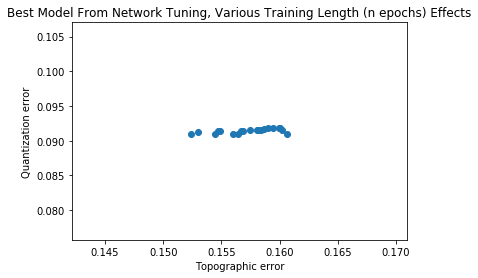

In [53]:
plt.scatter(e_top_r3, e_q_r3)
plt.title("Best Model From Network Tuning, Various Training Length (n epochs) Effects")
plt.xlabel("Topographic error")
plt.ylabel("Quantization error")
plt.show()

In [49]:
res = []
for i, model_filepath in enumerate(models_pool_r3):
    res.append({'model': model_filepath, 'topographical_error': e_top_r3[i], 'quantization_error': e_q_r3[i]})
    #print(model_filepath)
    #name.append(model_filepath[3:10])
    #err_top.append(e_top[i])
    #err_quant.append(e_q[i])

results_df = pd.DataFrame(res)
results_df.sort_values(['topographical_error'], ascending=True)
#print(model_filepath,e_top[i],e_q[i])

,model,quantization_error,topographical_error
2,.\model_mean_opt_r3_epochs_10.joblib,0.090950,0.152431
8,.\model_mean_opt_r3_epochs_16.joblib,0.091271,0.152991
11,.\model_mean_opt_r3_epochs_19.joblib,0.090944,0.154454
18,.\model_mean_opt_r3_epochs_8.joblib,0.091472,0.154722
6,.\model_mean_opt_r3_epochs_14.joblib,0.091376,0.154843
13,.\model_mean_opt_r3_epochs_3.joblib,0.090950,0.156013
7,.\model_mean_opt_r3_epochs_15.joblib,0.090948,0.156452
0,.\model_mean_opt_r3_epochs_0.joblib,0.091345,0.156720
19,.\model_mean_opt_r3_epochs_9.joblib,0.091465,0.156890
17,.\model_mean_opt_r3_epochs_7.joblib,0.091553,0.157427


#### Details on r3 opt model 10
* Trainlen on higher end of rough stage range
* Could feasibly get addt'l topological error reduction with longer fine tuning length (more epochs)
Training...
 pca_linear_initialization took: 0.065000 seconds
 Rough training...
 radius_ini: 5.000000 , radius_final: 1.250000, trainlen: 39
 Finetune training...
 radius_ini: 1.250000 , radius_final: 1.000000, trainlen: 78              

In [50]:
optimized = joblib.load('C:\\Users\goyetc\\SOMPY\\model_mean_opt_r3_epochs_10.joblib')
optimized.__dict__

{'_bmu': array([[  1.05000000e+02,   1.05000000e+02,   1.05000000e+02, ...,
           8.62000000e+02,   8.62000000e+02,   8.62000000e+02],
        [  1.65762096e+00,   1.67275687e+00,   1.68548998e+00, ...,
           2.49997359e-02,   2.46383805e-02,   2.42878250e-02]]),
 '_component_names': [['SSS', 'SST', 'MLD', 'pCO2']],
 '_data': array([[ 0.18913603, -1.3459917 ,  3.41670057, -2.6790296 ],
        [ 0.17588447, -1.3475531 ,  3.41021886, -2.69762985],
        [ 0.15916678, -1.34988534,  3.38340523, -2.72281208],
        ..., 
        [-0.84256275, -1.39285668, -0.15187448, -1.19543379],
        [-0.84284339, -1.39285576, -0.15225229, -1.19487994],
        [-0.84312895, -1.39285485, -0.15263131, -1.19433144]]),
 '_dim': 4L,
 '_distance_matrix': array([[  0.00000000e+00,   1.00000000e+00,   4.00000000e+00, ...,
           1.80800000e+03,   1.87300000e+03,   1.94000000e+03],
        [  1.00000000e+00,   0.00000000e+00,   1.00000000e+00, ...,
           1.74500000e+03,   1.80800000e+0

In [51]:
optimized.calculate_topographic_error()

 find_bmu took: 0.674000 seconds
 find_bmu took: 0.862000 seconds


0.1524308517119532

In [117]:
# based on prior optimization, now use "optimized" Model to produce Monthly SOMs 
map_best = [29, 35] 
init = 'pca'
names = ['SSS','SST','log_MLD','pCO2']
tr = 100
tf = 200

for i in range(12):
    ss = StandardScaler().fit_transform(Monthly['month-'+str(i+1)][['SSS','SST','log_MLD','pCO2']])
    
    
    sm = sompy.SOMFactory().build(ss, mapsize = map_best, mapshape = 'planar',
                            initialization= init,
                            normalization = None, 
                            component_names=names, lattice='rect') 
    sm.train(n_job=1, 
             verbose='info', 
             train_rough_len=tr,
             train_finetune_len=tf,
             #train_rough_radiusin=14,
             #train_rough_radiusfin=3.5,
             #train_finetune_radiusin=3.5,
             #train_finetune_radiusfin=1
            ) 
    
    joblib.dump(sm, "optimized_month_pca_100_200_logMLD_{}.joblib".format(i+1))

 Training...
 pca_linear_initialization took: 0.073000 seconds
 Rough training...
 radius_ini: 5.000000 , radius_final: 1.250000, trainlen: 100

 epoch: 1 ---> elapsed time:  0.830000, quantization error: 0.996977

 epoch: 2 ---> elapsed time:  0.822000, quantization error: 0.752962

 epoch: 3 ---> elapsed time:  0.883000, quantization error: 0.658155

 epoch: 4 ---> elapsed time:  0.984000, quantization error: 0.638139

 epoch: 5 ---> elapsed time:  0.706000, quantization error: 0.627655

 epoch: 6 ---> elapsed time:  0.817000, quantization error: 0.619064

 epoch: 7 ---> elapsed time:  1.003000, quantization error: 0.611879

 epoch: 8 ---> elapsed time:  0.784000, quantization error: 0.606515

 epoch: 9 ---> elapsed time:  0.789000, quantization error: 0.602103

 epoch: 10 ---> elapsed time:  0.787000, quantization error: 0.598242

 epoch: 11 ---> elapsed time:  0.711000, quantization error: 0.594578

 epoch: 12 ---> elapsed time:  0.707000, quantization error: 0.591010

 epoch: 13 -

 epoch: 14 ---> elapsed time:  0.885000, quantization error: 0.231513

 epoch: 15 ---> elapsed time:  0.769000, quantization error: 0.231329

 epoch: 16 ---> elapsed time:  0.790000, quantization error: 0.231140

 epoch: 17 ---> elapsed time:  0.768000, quantization error: 0.230983

 epoch: 18 ---> elapsed time:  0.774000, quantization error: 0.230817

 epoch: 19 ---> elapsed time:  0.769000, quantization error: 0.230673

 epoch: 20 ---> elapsed time:  0.810000, quantization error: 0.230531

 epoch: 21 ---> elapsed time:  0.765000, quantization error: 0.230365

 epoch: 22 ---> elapsed time:  0.873000, quantization error: 0.230195

 epoch: 23 ---> elapsed time:  0.700000, quantization error: 0.230066

 epoch: 24 ---> elapsed time:  1.084000, quantization error: 0.229904

 epoch: 25 ---> elapsed time:  0.979000, quantization error: 0.229754

 epoch: 26 ---> elapsed time:  0.777000, quantization error: 0.229557

 epoch: 27 ---> elapsed time:  0.802000, quantization error: 0.229340

 epoch

 epoch: 129 ---> elapsed time:  0.888000, quantization error: 0.213585

 epoch: 130 ---> elapsed time:  0.909000, quantization error: 0.213437

 epoch: 131 ---> elapsed time:  0.915000, quantization error: 0.213274

 epoch: 132 ---> elapsed time:  1.237000, quantization error: 0.213131

 epoch: 133 ---> elapsed time:  1.223000, quantization error: 0.212986

 epoch: 134 ---> elapsed time:  0.775000, quantization error: 0.212833

 epoch: 135 ---> elapsed time:  0.791000, quantization error: 0.212686

 epoch: 136 ---> elapsed time:  0.782000, quantization error: 0.212552

 epoch: 137 ---> elapsed time:  0.782000, quantization error: 0.212409

 epoch: 138 ---> elapsed time:  0.772000, quantization error: 0.212264

 epoch: 139 ---> elapsed time:  0.771000, quantization error: 0.212130

 epoch: 140 ---> elapsed time:  0.771000, quantization error: 0.211996

 epoch: 141 ---> elapsed time:  0.780000, quantization error: 0.211854

 epoch: 142 ---> elapsed time:  0.867000, quantization error: 0.

 epoch: 41 ---> elapsed time:  0.980000, quantization error: 0.486904

 epoch: 42 ---> elapsed time:  1.102000, quantization error: 0.483188

 epoch: 43 ---> elapsed time:  1.019000, quantization error: 0.479510

 epoch: 44 ---> elapsed time:  1.023000, quantization error: 0.475844

 epoch: 45 ---> elapsed time:  0.974000, quantization error: 0.472121

 epoch: 46 ---> elapsed time:  0.889000, quantization error: 0.468463

 epoch: 47 ---> elapsed time:  0.772000, quantization error: 0.464769

 epoch: 48 ---> elapsed time:  0.764000, quantization error: 0.461127

 epoch: 49 ---> elapsed time:  0.873000, quantization error: 0.457536

 epoch: 50 ---> elapsed time:  0.896000, quantization error: 0.453921

 epoch: 51 ---> elapsed time:  0.948000, quantization error: 0.450159

 epoch: 52 ---> elapsed time:  0.985000, quantization error: 0.446350

 epoch: 53 ---> elapsed time:  0.873000, quantization error: 0.442441

 epoch: 54 ---> elapsed time:  0.774000, quantization error: 0.438479

 epoch

 epoch: 56 ---> elapsed time:  0.813000, quantization error: 0.234469

 epoch: 57 ---> elapsed time:  0.710000, quantization error: 0.234307

 epoch: 58 ---> elapsed time:  0.780000, quantization error: 0.234119

 epoch: 59 ---> elapsed time:  0.696000, quantization error: 0.233959

 epoch: 60 ---> elapsed time:  0.825000, quantization error: 0.233795

 epoch: 61 ---> elapsed time:  0.806000, quantization error: 0.233619

 epoch: 62 ---> elapsed time:  0.706000, quantization error: 0.233458

 epoch: 63 ---> elapsed time:  0.709000, quantization error: 0.233306

 epoch: 64 ---> elapsed time:  0.771000, quantization error: 0.233148

 epoch: 65 ---> elapsed time:  0.769000, quantization error: 0.232995

 epoch: 66 ---> elapsed time:  0.916000, quantization error: 0.232830

 epoch: 67 ---> elapsed time:  1.028000, quantization error: 0.232670

 epoch: 68 ---> elapsed time:  0.890000, quantization error: 0.232504

 epoch: 69 ---> elapsed time:  0.899000, quantization error: 0.232337

 epoch

 epoch: 171 ---> elapsed time:  0.802000, quantization error: 0.216364

 epoch: 172 ---> elapsed time:  0.773000, quantization error: 0.216208

 epoch: 173 ---> elapsed time:  0.710000, quantization error: 0.216055

 epoch: 174 ---> elapsed time:  0.715000, quantization error: 0.215906

 epoch: 175 ---> elapsed time:  0.798000, quantization error: 0.215759

 epoch: 176 ---> elapsed time:  0.776000, quantization error: 0.215611

 epoch: 177 ---> elapsed time:  1.005000, quantization error: 0.215467

 epoch: 178 ---> elapsed time:  0.980000, quantization error: 0.215307

 epoch: 179 ---> elapsed time:  0.816000, quantization error: 0.215168

 epoch: 180 ---> elapsed time:  0.795000, quantization error: 0.215017

 epoch: 181 ---> elapsed time:  0.830000, quantization error: 0.214882

 epoch: 182 ---> elapsed time:  0.724000, quantization error: 0.214741

 epoch: 183 ---> elapsed time:  0.944000, quantization error: 0.214593

 epoch: 184 ---> elapsed time:  0.940000, quantization error: 0.

 epoch: 84 ---> elapsed time:  0.719000, quantization error: 0.337218

 epoch: 85 ---> elapsed time:  0.696000, quantization error: 0.332567

 epoch: 86 ---> elapsed time:  0.939000, quantization error: 0.327857

 epoch: 87 ---> elapsed time:  0.937000, quantization error: 0.323143

 epoch: 88 ---> elapsed time:  1.037000, quantization error: 0.318402

 epoch: 89 ---> elapsed time:  0.926000, quantization error: 0.313658

 epoch: 90 ---> elapsed time:  0.831000, quantization error: 0.308905

 epoch: 91 ---> elapsed time:  0.814000, quantization error: 0.304145

 epoch: 92 ---> elapsed time:  0.807000, quantization error: 0.299405

 epoch: 93 ---> elapsed time:  0.696000, quantization error: 0.294604

 epoch: 94 ---> elapsed time:  0.801000, quantization error: 0.289924

 epoch: 95 ---> elapsed time:  0.808000, quantization error: 0.285226

 epoch: 96 ---> elapsed time:  0.825000, quantization error: 0.280622

 epoch: 97 ---> elapsed time:  0.688000, quantization error: 0.276009

 epoch

 epoch: 99 ---> elapsed time:  0.772000, quantization error: 0.236807

 epoch: 100 ---> elapsed time:  0.798000, quantization error: 0.236646

 epoch: 101 ---> elapsed time:  0.986000, quantization error: 0.236473

 epoch: 102 ---> elapsed time:  0.985000, quantization error: 0.236301

 epoch: 103 ---> elapsed time:  0.870000, quantization error: 0.236117

 epoch: 104 ---> elapsed time:  0.871000, quantization error: 0.235932

 epoch: 105 ---> elapsed time:  0.787000, quantization error: 0.235776

 epoch: 106 ---> elapsed time:  0.694000, quantization error: 0.235601

 epoch: 107 ---> elapsed time:  0.881000, quantization error: 0.235441

 epoch: 108 ---> elapsed time:  0.882000, quantization error: 0.235263

 epoch: 109 ---> elapsed time:  0.791000, quantization error: 0.235112

 epoch: 110 ---> elapsed time:  0.817000, quantization error: 0.234946

 epoch: 111 ---> elapsed time:  0.754000, quantization error: 0.234798

 epoch: 112 ---> elapsed time:  1.070000, quantization error: 0.2

 epoch: 11 ---> elapsed time:  0.810000, quantization error: 0.633367

 epoch: 12 ---> elapsed time:  0.894000, quantization error: 0.630468

 epoch: 13 ---> elapsed time:  0.900000, quantization error: 0.627529

 epoch: 14 ---> elapsed time:  0.991000, quantization error: 0.624460

 epoch: 15 ---> elapsed time:  0.777000, quantization error: 0.621424

 epoch: 16 ---> elapsed time:  0.805000, quantization error: 0.618277

 epoch: 17 ---> elapsed time:  0.780000, quantization error: 0.615205

 epoch: 18 ---> elapsed time:  0.803000, quantization error: 0.612175

 epoch: 19 ---> elapsed time:  0.823000, quantization error: 0.609092

 epoch: 20 ---> elapsed time:  1.019000, quantization error: 0.606031

 epoch: 21 ---> elapsed time:  0.909000, quantization error: 0.602935

 epoch: 22 ---> elapsed time:  0.810000, quantization error: 0.599801

 epoch: 23 ---> elapsed time:  0.912000, quantization error: 0.596653

 epoch: 24 ---> elapsed time:  0.987000, quantization error: 0.593378

 epoch

 epoch: 26 ---> elapsed time:  0.791000, quantization error: 0.260789

 epoch: 27 ---> elapsed time:  0.817000, quantization error: 0.260592

 epoch: 28 ---> elapsed time:  0.912000, quantization error: 0.260421

 epoch: 29 ---> elapsed time:  0.893000, quantization error: 0.260264

 epoch: 30 ---> elapsed time:  0.886000, quantization error: 0.260122

 epoch: 31 ---> elapsed time:  0.990000, quantization error: 0.259972

 epoch: 32 ---> elapsed time:  1.011000, quantization error: 0.259805

 epoch: 33 ---> elapsed time:  0.994000, quantization error: 0.259625

 epoch: 34 ---> elapsed time:  0.777000, quantization error: 0.259449

 epoch: 35 ---> elapsed time:  0.810000, quantization error: 0.259294

 epoch: 36 ---> elapsed time:  0.893000, quantization error: 0.259134

 epoch: 37 ---> elapsed time:  0.877000, quantization error: 0.258973

 epoch: 38 ---> elapsed time:  0.886000, quantization error: 0.258813

 epoch: 39 ---> elapsed time:  0.807000, quantization error: 0.258636

 epoch

 epoch: 141 ---> elapsed time:  1.193000, quantization error: 0.240088

 epoch: 142 ---> elapsed time:  0.910000, quantization error: 0.239934

 epoch: 143 ---> elapsed time:  0.784000, quantization error: 0.239759

 epoch: 144 ---> elapsed time:  0.887000, quantization error: 0.239599

 epoch: 145 ---> elapsed time:  0.875000, quantization error: 0.239445

 epoch: 146 ---> elapsed time:  0.785000, quantization error: 0.239289

 epoch: 147 ---> elapsed time:  0.886000, quantization error: 0.239098

 epoch: 148 ---> elapsed time:  0.803000, quantization error: 0.238947

 epoch: 149 ---> elapsed time:  0.769000, quantization error: 0.238781

 epoch: 150 ---> elapsed time:  0.781000, quantization error: 0.238635

 epoch: 151 ---> elapsed time:  0.871000, quantization error: 0.238464

 epoch: 152 ---> elapsed time:  0.776000, quantization error: 0.238306

 epoch: 153 ---> elapsed time:  0.788000, quantization error: 0.238149

 epoch: 154 ---> elapsed time:  0.769000, quantization error: 0.

 epoch: 53 ---> elapsed time:  0.773000, quantization error: 0.444720

 epoch: 54 ---> elapsed time:  0.890000, quantization error: 0.441292

 epoch: 55 ---> elapsed time:  0.794000, quantization error: 0.437807

 epoch: 56 ---> elapsed time:  0.779000, quantization error: 0.434306

 epoch: 57 ---> elapsed time:  0.778000, quantization error: 0.430690

 epoch: 58 ---> elapsed time:  0.792000, quantization error: 0.427165

 epoch: 59 ---> elapsed time:  0.781000, quantization error: 0.423652

 epoch: 60 ---> elapsed time:  0.782000, quantization error: 0.420057

 epoch: 61 ---> elapsed time:  0.782000, quantization error: 0.416397

 epoch: 62 ---> elapsed time:  0.775000, quantization error: 0.412730

 epoch: 63 ---> elapsed time:  0.794000, quantization error: 0.408966

 epoch: 64 ---> elapsed time:  0.888000, quantization error: 0.405254

 epoch: 65 ---> elapsed time:  1.312000, quantization error: 0.401512

 epoch: 66 ---> elapsed time:  0.900000, quantization error: 0.397749

 epoch

 epoch: 68 ---> elapsed time:  0.816000, quantization error: 0.244057

 epoch: 69 ---> elapsed time:  0.771000, quantization error: 0.243892

 epoch: 70 ---> elapsed time:  0.768000, quantization error: 0.243748

 epoch: 71 ---> elapsed time:  0.775000, quantization error: 0.243603

 epoch: 72 ---> elapsed time:  0.796000, quantization error: 0.243447

 epoch: 73 ---> elapsed time:  0.883000, quantization error: 0.243295

 epoch: 74 ---> elapsed time:  0.903000, quantization error: 0.243156

 epoch: 75 ---> elapsed time:  1.098000, quantization error: 0.242982

 epoch: 76 ---> elapsed time:  1.005000, quantization error: 0.242863

 epoch: 77 ---> elapsed time:  0.796000, quantization error: 0.242726

 epoch: 78 ---> elapsed time:  0.781000, quantization error: 0.242594

 epoch: 79 ---> elapsed time:  0.993000, quantization error: 0.242467

 epoch: 80 ---> elapsed time:  0.884000, quantization error: 0.242327

 epoch: 81 ---> elapsed time:  0.772000, quantization error: 0.242191

 epoch

 epoch: 183 ---> elapsed time:  0.870000, quantization error: 0.227203

 epoch: 184 ---> elapsed time:  0.790000, quantization error: 0.227057

 epoch: 185 ---> elapsed time:  0.986000, quantization error: 0.226916

 epoch: 186 ---> elapsed time:  0.987000, quantization error: 0.226783

 epoch: 187 ---> elapsed time:  0.883000, quantization error: 0.226626

 epoch: 188 ---> elapsed time:  0.777000, quantization error: 0.226478

 epoch: 189 ---> elapsed time:  0.785000, quantization error: 0.226344

 epoch: 190 ---> elapsed time:  0.896000, quantization error: 0.226210

 epoch: 191 ---> elapsed time:  0.776000, quantization error: 0.226057

 epoch: 192 ---> elapsed time:  0.785000, quantization error: 0.225919

 epoch: 193 ---> elapsed time:  0.788000, quantization error: 0.225787

 epoch: 194 ---> elapsed time:  0.888000, quantization error: 0.225647

 epoch: 195 ---> elapsed time:  0.888000, quantization error: 0.225519

 epoch: 196 ---> elapsed time:  0.877000, quantization error: 0.

 epoch: 96 ---> elapsed time:  0.796000, quantization error: 0.230922

 epoch: 97 ---> elapsed time:  0.802000, quantization error: 0.227469

 epoch: 98 ---> elapsed time:  0.783000, quantization error: 0.224010

 epoch: 99 ---> elapsed time:  0.801000, quantization error: 0.220560

 epoch: 100 ---> elapsed time:  0.920000, quantization error: 0.217091

 Finetune training...
 radius_ini: 1.250000 , radius_final: 1.000000, trainlen: 200

 epoch: 1 ---> elapsed time:  0.908000, quantization error: 0.213601

 epoch: 2 ---> elapsed time:  0.760000, quantization error: 0.213029

 epoch: 3 ---> elapsed time:  0.776000, quantization error: 0.212551

 epoch: 4 ---> elapsed time:  0.717000, quantization error: 0.212197

 epoch: 5 ---> elapsed time:  0.775000, quantization error: 0.211917

 epoch: 6 ---> elapsed time:  0.772000, quantization error: 0.211567

 epoch: 7 ---> elapsed time:  0.872000, quantization error: 0.211305

 epoch: 8 ---> elapsed time:  0.780000, quantization error: 0.211044


 epoch: 111 ---> elapsed time:  0.701000, quantization error: 0.197105

 epoch: 112 ---> elapsed time:  0.768000, quantization error: 0.196993

 epoch: 113 ---> elapsed time:  0.815000, quantization error: 0.196875

 epoch: 114 ---> elapsed time:  0.687000, quantization error: 0.196761

 epoch: 115 ---> elapsed time:  0.890000, quantization error: 0.196645

 epoch: 116 ---> elapsed time:  1.125000, quantization error: 0.196528

 epoch: 117 ---> elapsed time:  0.946000, quantization error: 0.196417

 epoch: 118 ---> elapsed time:  1.012000, quantization error: 0.196298

 epoch: 119 ---> elapsed time:  1.313000, quantization error: 0.196189

 epoch: 120 ---> elapsed time:  0.992000, quantization error: 0.196083

 epoch: 121 ---> elapsed time:  0.815000, quantization error: 0.195957

 epoch: 122 ---> elapsed time:  0.818000, quantization error: 0.195823

 epoch: 123 ---> elapsed time:  0.810000, quantization error: 0.195693

 epoch: 124 ---> elapsed time:  0.879000, quantization error: 0.

 epoch: 23 ---> elapsed time:  0.777000, quantization error: 0.405773

 epoch: 24 ---> elapsed time:  0.797000, quantization error: 0.403023

 epoch: 25 ---> elapsed time:  0.916000, quantization error: 0.400240

 epoch: 26 ---> elapsed time:  0.885000, quantization error: 0.397481

 epoch: 27 ---> elapsed time:  1.121000, quantization error: 0.394772

 epoch: 28 ---> elapsed time:  0.874000, quantization error: 0.392054

 epoch: 29 ---> elapsed time:  0.793000, quantization error: 0.389343

 epoch: 30 ---> elapsed time:  0.900000, quantization error: 0.386535

 epoch: 31 ---> elapsed time:  0.881000, quantization error: 0.383745

 epoch: 32 ---> elapsed time:  0.785000, quantization error: 0.380964

 epoch: 33 ---> elapsed time:  0.766000, quantization error: 0.378129

 epoch: 34 ---> elapsed time:  0.813000, quantization error: 0.375286

 epoch: 35 ---> elapsed time:  0.772000, quantization error: 0.372413

 epoch: 36 ---> elapsed time:  0.801000, quantization error: 0.369528

 epoch

 epoch: 38 ---> elapsed time:  0.794000, quantization error: 0.167628

 epoch: 39 ---> elapsed time:  0.771000, quantization error: 0.167523

 epoch: 40 ---> elapsed time:  0.768000, quantization error: 0.167421

 epoch: 41 ---> elapsed time:  0.810000, quantization error: 0.167323

 epoch: 42 ---> elapsed time:  0.893000, quantization error: 0.167203

 epoch: 43 ---> elapsed time:  0.892000, quantization error: 0.167089

 epoch: 44 ---> elapsed time:  0.784000, quantization error: 0.166982

 epoch: 45 ---> elapsed time:  0.815000, quantization error: 0.166893

 epoch: 46 ---> elapsed time:  0.887000, quantization error: 0.166796

 epoch: 47 ---> elapsed time:  0.795000, quantization error: 0.166709

 epoch: 48 ---> elapsed time:  0.918000, quantization error: 0.166618

 epoch: 49 ---> elapsed time:  0.981000, quantization error: 0.166534

 epoch: 50 ---> elapsed time:  0.902000, quantization error: 0.166440

 epoch: 51 ---> elapsed time:  0.827000, quantization error: 0.166342

 epoch

 epoch: 153 ---> elapsed time:  0.974000, quantization error: 0.155481

 epoch: 154 ---> elapsed time:  1.115000, quantization error: 0.155349

 epoch: 155 ---> elapsed time:  0.900000, quantization error: 0.155224

 epoch: 156 ---> elapsed time:  0.917000, quantization error: 0.155114

 epoch: 157 ---> elapsed time:  0.824000, quantization error: 0.155010

 epoch: 158 ---> elapsed time:  0.708000, quantization error: 0.154911

 epoch: 159 ---> elapsed time:  0.900000, quantization error: 0.154818

 epoch: 160 ---> elapsed time:  0.926000, quantization error: 0.154713

 epoch: 161 ---> elapsed time:  1.093000, quantization error: 0.154606

 epoch: 162 ---> elapsed time:  0.790000, quantization error: 0.154505

 epoch: 163 ---> elapsed time:  0.756000, quantization error: 0.154403

 epoch: 164 ---> elapsed time:  0.802000, quantization error: 0.154310

 epoch: 165 ---> elapsed time:  0.797000, quantization error: 0.154211

 epoch: 166 ---> elapsed time:  0.787000, quantization error: 0.

 epoch: 65 ---> elapsed time:  0.924000, quantization error: 0.271166

 epoch: 66 ---> elapsed time:  0.826000, quantization error: 0.268459

 epoch: 67 ---> elapsed time:  0.784000, quantization error: 0.265743

 epoch: 68 ---> elapsed time:  0.706000, quantization error: 0.263040

 epoch: 69 ---> elapsed time:  0.820000, quantization error: 0.260329

 epoch: 70 ---> elapsed time:  0.821000, quantization error: 0.257653

 epoch: 71 ---> elapsed time:  0.802000, quantization error: 0.254891

 epoch: 72 ---> elapsed time:  0.812000, quantization error: 0.252150

 epoch: 73 ---> elapsed time:  0.722000, quantization error: 0.249407

 epoch: 74 ---> elapsed time:  0.701000, quantization error: 0.246676

 epoch: 75 ---> elapsed time:  0.813000, quantization error: 0.243961

 epoch: 76 ---> elapsed time:  0.875000, quantization error: 0.241192

 epoch: 77 ---> elapsed time:  0.688000, quantization error: 0.238365

 epoch: 78 ---> elapsed time:  0.800000, quantization error: 0.235496

 epoch

 epoch: 80 ---> elapsed time:  0.792000, quantization error: 0.159124

 epoch: 81 ---> elapsed time:  0.782000, quantization error: 0.159037

 epoch: 82 ---> elapsed time:  0.946000, quantization error: 0.158939

 epoch: 83 ---> elapsed time:  1.013000, quantization error: 0.158853

 epoch: 84 ---> elapsed time:  0.999000, quantization error: 0.158760

 epoch: 85 ---> elapsed time:  0.957000, quantization error: 0.158672

 epoch: 86 ---> elapsed time:  0.780000, quantization error: 0.158572

 epoch: 87 ---> elapsed time:  0.698000, quantization error: 0.158479

 epoch: 88 ---> elapsed time:  0.776000, quantization error: 0.158379

 epoch: 89 ---> elapsed time:  0.789000, quantization error: 0.158275

 epoch: 90 ---> elapsed time:  0.787000, quantization error: 0.158173

 epoch: 91 ---> elapsed time:  0.916000, quantization error: 0.158090

 epoch: 92 ---> elapsed time:  0.883000, quantization error: 0.157991

 epoch: 93 ---> elapsed time:  1.061000, quantization error: 0.157892

 epoch

 epoch: 195 ---> elapsed time:  0.801000, quantization error: 0.148116

 epoch: 196 ---> elapsed time:  0.826000, quantization error: 0.148013

 epoch: 197 ---> elapsed time:  0.818000, quantization error: 0.147926

 epoch: 198 ---> elapsed time:  0.692000, quantization error: 0.147821

 epoch: 199 ---> elapsed time:  0.688000, quantization error: 0.147735

 epoch: 200 ---> elapsed time:  0.811000, quantization error: 0.147644

 Final quantization error: 0.147644
 train took: 264.062000 seconds
 Training...
 pca_linear_initialization took: 0.051000 seconds
 Rough training...
 radius_ini: 5.000000 , radius_final: 1.250000, trainlen: 100

 epoch: 1 ---> elapsed time:  0.704000, quantization error: 0.843895

 epoch: 2 ---> elapsed time:  0.693000, quantization error: 0.525619

 epoch: 3 ---> elapsed time:  0.697000, quantization error: 0.484570

 epoch: 4 ---> elapsed time:  0.839000, quantization error: 0.476187

 epoch: 5 ---> elapsed time:  0.718000, quantization error: 0.470122

 epoc

 epoch: 7 ---> elapsed time:  0.797000, quantization error: 0.184108

 epoch: 8 ---> elapsed time:  0.928000, quantization error: 0.183961

 epoch: 9 ---> elapsed time:  0.781000, quantization error: 0.183796

 epoch: 10 ---> elapsed time:  0.765000, quantization error: 0.183649

 epoch: 11 ---> elapsed time:  0.766000, quantization error: 0.183518

 epoch: 12 ---> elapsed time:  0.774000, quantization error: 0.183377

 epoch: 13 ---> elapsed time:  0.784000, quantization error: 0.183231

 epoch: 14 ---> elapsed time:  0.878000, quantization error: 0.183061

 epoch: 15 ---> elapsed time:  0.792000, quantization error: 0.182886

 epoch: 16 ---> elapsed time:  0.767000, quantization error: 0.182733

 epoch: 17 ---> elapsed time:  0.872000, quantization error: 0.182595

 epoch: 18 ---> elapsed time:  0.786000, quantization error: 0.182466

 epoch: 19 ---> elapsed time:  0.783000, quantization error: 0.182346

 epoch: 20 ---> elapsed time:  0.819000, quantization error: 0.182235

 epoch: 2

 epoch: 123 ---> elapsed time:  0.769000, quantization error: 0.171575

 epoch: 124 ---> elapsed time:  0.769000, quantization error: 0.171484

 epoch: 125 ---> elapsed time:  0.782000, quantization error: 0.171381

 epoch: 126 ---> elapsed time:  0.795000, quantization error: 0.171269

 epoch: 127 ---> elapsed time:  0.919000, quantization error: 0.171170

 epoch: 128 ---> elapsed time:  0.933000, quantization error: 0.171077

 epoch: 129 ---> elapsed time:  0.816000, quantization error: 0.170978

 epoch: 130 ---> elapsed time:  0.916000, quantization error: 0.170880

 epoch: 131 ---> elapsed time:  0.932000, quantization error: 0.170781

 epoch: 132 ---> elapsed time:  0.903000, quantization error: 0.170679

 epoch: 133 ---> elapsed time:  1.137000, quantization error: 0.170580

 epoch: 134 ---> elapsed time:  0.720000, quantization error: 0.170497

 epoch: 135 ---> elapsed time:  0.897000, quantization error: 0.170401

 epoch: 136 ---> elapsed time:  0.792000, quantization error: 0.

 epoch: 35 ---> elapsed time:  0.799000, quantization error: 0.469354

 epoch: 36 ---> elapsed time:  0.722000, quantization error: 0.465770

 epoch: 37 ---> elapsed time:  0.704000, quantization error: 0.462212

 epoch: 38 ---> elapsed time:  0.705000, quantization error: 0.458643

 epoch: 39 ---> elapsed time:  0.719000, quantization error: 0.455013

 epoch: 40 ---> elapsed time:  0.714000, quantization error: 0.451293

 epoch: 41 ---> elapsed time:  0.699000, quantization error: 0.447647

 epoch: 42 ---> elapsed time:  0.691000, quantization error: 0.444016

 epoch: 43 ---> elapsed time:  0.714000, quantization error: 0.440362

 epoch: 44 ---> elapsed time:  0.705000, quantization error: 0.436725

 epoch: 45 ---> elapsed time:  0.709000, quantization error: 0.433092

 epoch: 46 ---> elapsed time:  0.702000, quantization error: 0.429477

 epoch: 47 ---> elapsed time:  0.845000, quantization error: 0.425812

 epoch: 48 ---> elapsed time:  0.825000, quantization error: 0.422151

 epoch

 epoch: 50 ---> elapsed time:  0.701000, quantization error: 0.216904

 epoch: 51 ---> elapsed time:  0.798000, quantization error: 0.216781

 epoch: 52 ---> elapsed time:  0.917000, quantization error: 0.216654

 epoch: 53 ---> elapsed time:  0.808000, quantization error: 0.216540

 epoch: 54 ---> elapsed time:  0.712000, quantization error: 0.216414

 epoch: 55 ---> elapsed time:  0.694000, quantization error: 0.216297

 epoch: 56 ---> elapsed time:  0.829000, quantization error: 0.216176

 epoch: 57 ---> elapsed time:  0.803000, quantization error: 0.216053

 epoch: 58 ---> elapsed time:  0.699000, quantization error: 0.215932

 epoch: 59 ---> elapsed time:  0.711000, quantization error: 0.215799

 epoch: 60 ---> elapsed time:  0.789000, quantization error: 0.215665

 epoch: 61 ---> elapsed time:  0.829000, quantization error: 0.215547

 epoch: 62 ---> elapsed time:  0.707000, quantization error: 0.215425

 epoch: 63 ---> elapsed time:  0.701000, quantization error: 0.215298

 epoch

 epoch: 165 ---> elapsed time:  0.794000, quantization error: 0.202529

 epoch: 166 ---> elapsed time:  0.778000, quantization error: 0.202408

 epoch: 167 ---> elapsed time:  0.798000, quantization error: 0.202293

 epoch: 168 ---> elapsed time:  0.877000, quantization error: 0.202182

 epoch: 169 ---> elapsed time:  1.193000, quantization error: 0.202053

 epoch: 170 ---> elapsed time:  1.115000, quantization error: 0.201931

 epoch: 171 ---> elapsed time:  0.892000, quantization error: 0.201816

 epoch: 172 ---> elapsed time:  0.876000, quantization error: 0.201682

 epoch: 173 ---> elapsed time:  0.867000, quantization error: 0.201557

 epoch: 174 ---> elapsed time:  0.768000, quantization error: 0.201433

 epoch: 175 ---> elapsed time:  0.766000, quantization error: 0.201312

 epoch: 176 ---> elapsed time:  0.797000, quantization error: 0.201190

 epoch: 177 ---> elapsed time:  0.771000, quantization error: 0.201078

 epoch: 178 ---> elapsed time:  0.776000, quantization error: 0.

 epoch: 78 ---> elapsed time:  0.977000, quantization error: 0.368090

 epoch: 79 ---> elapsed time:  0.772000, quantization error: 0.363752

 epoch: 80 ---> elapsed time:  1.191000, quantization error: 0.359327

 epoch: 81 ---> elapsed time:  0.872000, quantization error: 0.354899

 epoch: 82 ---> elapsed time:  0.885000, quantization error: 0.350481

 epoch: 83 ---> elapsed time:  0.885000, quantization error: 0.345906

 epoch: 84 ---> elapsed time:  0.765000, quantization error: 0.341221

 epoch: 85 ---> elapsed time:  0.767000, quantization error: 0.336459

 epoch: 86 ---> elapsed time:  0.763000, quantization error: 0.331740

 epoch: 87 ---> elapsed time:  0.777000, quantization error: 0.327056

 epoch: 88 ---> elapsed time:  0.773000, quantization error: 0.322231

 epoch: 89 ---> elapsed time:  0.763000, quantization error: 0.317512

 epoch: 90 ---> elapsed time:  0.766000, quantization error: 0.312743

 epoch: 91 ---> elapsed time:  0.766000, quantization error: 0.307991

 epoch

 epoch: 93 ---> elapsed time:  0.880000, quantization error: 0.244761

 epoch: 94 ---> elapsed time:  0.765000, quantization error: 0.244609

 epoch: 95 ---> elapsed time:  0.763000, quantization error: 0.244461

 epoch: 96 ---> elapsed time:  0.770000, quantization error: 0.244316

 epoch: 97 ---> elapsed time:  0.772000, quantization error: 0.244175

 epoch: 98 ---> elapsed time:  0.775000, quantization error: 0.243993

 epoch: 99 ---> elapsed time:  0.767000, quantization error: 0.243806

 epoch: 100 ---> elapsed time:  0.774000, quantization error: 0.243633

 epoch: 101 ---> elapsed time:  0.765000, quantization error: 0.243463

 epoch: 102 ---> elapsed time:  0.778000, quantization error: 0.243258

 epoch: 103 ---> elapsed time:  0.882000, quantization error: 0.243065

 epoch: 104 ---> elapsed time:  0.876000, quantization error: 0.242911

 epoch: 105 ---> elapsed time:  1.023000, quantization error: 0.242761

 epoch: 106 ---> elapsed time:  0.771000, quantization error: 0.242605


 epoch: 5 ---> elapsed time:  0.705000, quantization error: 0.673128

 epoch: 6 ---> elapsed time:  0.689000, quantization error: 0.666045

 epoch: 7 ---> elapsed time:  0.724000, quantization error: 0.658435

 epoch: 8 ---> elapsed time:  0.717000, quantization error: 0.646167

 epoch: 9 ---> elapsed time:  0.700000, quantization error: 0.637544

 epoch: 10 ---> elapsed time:  0.992000, quantization error: 0.631574

 epoch: 11 ---> elapsed time:  1.059000, quantization error: 0.626295

 epoch: 12 ---> elapsed time:  0.988000, quantization error: 0.621004

 epoch: 13 ---> elapsed time:  0.887000, quantization error: 0.616496

 epoch: 14 ---> elapsed time:  1.186000, quantization error: 0.612470

 epoch: 15 ---> elapsed time:  0.943000, quantization error: 0.608473

 epoch: 16 ---> elapsed time:  0.800000, quantization error: 0.604579

 epoch: 17 ---> elapsed time:  0.807000, quantization error: 0.600587

 epoch: 18 ---> elapsed time:  0.722000, quantization error: 0.596605

 epoch: 19 

 epoch: 20 ---> elapsed time:  0.687000, quantization error: 0.249022

 epoch: 21 ---> elapsed time:  0.904000, quantization error: 0.248829

 epoch: 22 ---> elapsed time:  0.861000, quantization error: 0.248659

 epoch: 23 ---> elapsed time:  0.782000, quantization error: 0.248484

 epoch: 24 ---> elapsed time:  0.888000, quantization error: 0.248307

 epoch: 25 ---> elapsed time:  0.797000, quantization error: 0.248107

 epoch: 26 ---> elapsed time:  0.779000, quantization error: 0.247924

 epoch: 27 ---> elapsed time:  0.793000, quantization error: 0.247746

 epoch: 28 ---> elapsed time:  0.811000, quantization error: 0.247531

 epoch: 29 ---> elapsed time:  0.801000, quantization error: 0.247319

 epoch: 30 ---> elapsed time:  0.765000, quantization error: 0.247142

 epoch: 31 ---> elapsed time:  0.791000, quantization error: 0.246955

 epoch: 32 ---> elapsed time:  0.900000, quantization error: 0.246799

 epoch: 33 ---> elapsed time:  0.889000, quantization error: 0.246617

 epoch

 epoch: 135 ---> elapsed time:  0.794000, quantization error: 0.230794

 epoch: 136 ---> elapsed time:  0.838000, quantization error: 0.230636

 epoch: 137 ---> elapsed time:  0.774000, quantization error: 0.230493

 epoch: 138 ---> elapsed time:  0.713000, quantization error: 0.230350

 epoch: 139 ---> elapsed time:  0.803000, quantization error: 0.230202

 epoch: 140 ---> elapsed time:  0.824000, quantization error: 0.230051

 epoch: 141 ---> elapsed time:  1.108000, quantization error: 0.229891

 epoch: 142 ---> elapsed time:  0.815000, quantization error: 0.229726

 epoch: 143 ---> elapsed time:  0.987000, quantization error: 0.229546

 epoch: 144 ---> elapsed time:  0.780000, quantization error: 0.229375

 epoch: 145 ---> elapsed time:  0.778000, quantization error: 0.229208

 epoch: 146 ---> elapsed time:  0.775000, quantization error: 0.229043

 epoch: 147 ---> elapsed time:  0.782000, quantization error: 0.228881

 epoch: 148 ---> elapsed time:  0.793000, quantization error: 0.

In [96]:
## Testing optimized model with randomized init instead of PCA. Note increased topo error
test = joblib.load('C:\\Users\goyetc\\SOMPY\\optimized_month_pca_100_200_logMLD_joblib')
te = test.calculate_topographic_error()
qe = test.calculate_quantization_error()
#optimized.__dict__

In [97]:
print('random init errors: ',te,qe)

(0.19919580845619594, 0.071451863678203678)


In [103]:
### Lengthened # of epochs in rough and fine tune.. some improvement to topo error vs standard 'optimized' model
test = joblib.load('C:\\Users\goyetc\\SOMPY\\optimized_month_pca_100_200_1.joblib')
te1 = test.calculate_topographic_error()
qe1 = test.calculate_quantization_error()
#optimized.__dict__

In [104]:
print(te1,qe1)

(0.1569635676861216, 0.071066783029647404)


#### Note: results above are the same with and without normalization within the SOM model, as we normalize with standard scaler in prior step

In [108]:
### log transform of MLD - improves topological error significantly (~20% reduction)
test_logMLD = joblib.load('C:\\Users\goyetc\\SOMPY\\optimized_month_pca_100_200_logMLD_1.joblib')
te_logMLD = test_logMLD.calculate_topographic_error()
qe_logMLD = test_logMLD.calculate_quantization_error()
#optimized.__dict__

In [109]:
print(te_logMLD, qe_logMLD)

(0.12798830266845376, 0.084700582586278356)


In [112]:
### RobustScaler v StandardScaler.. no error reduction observed
test_logMLD_robust = joblib.load('C:\\Users\goyetc\\SOMPY\\optimized_month_pca_100_200_logMLD_robust_1.joblib')
te_logMLD_robust = test_logMLD_robust.calculate_topographic_error()
qe_logMLD_robust = test_logMLD_robust.calculate_quantization_error()
#optimized.__dict__

In [115]:
### log transform of MLD - improves topological error significantly (~20% reduction)
test_logMLD_no_norm = joblib.load('C:\\Users\goyetc\\SOMPY\\optimized_month_pca_100_200_logMLD_no_norm_1.joblib')
te_logMLD_no_norm = test_logMLD_no_norm.calculate_topographic_error()
qe_logMLD_no_norm = test_logMLD_no_norm.calculate_quantization_error()
#optimized.__dict__

In [116]:
print(te_logMLD_no_norm, qe_logMLD_no_norm)

(0.12798830266845376, 0.084700582586278342)


In [99]:
test_pca_60_100 = joblib.load('C:\\Users\goyetc\\SOMPY\\optimized_month_pca_60_1001.joblib')
te2 = test_pca_60_100.calculate_topographic_error()
qe2 = test_pca_60_100.calculate_quantization_error()
#optimized.__dict__

In [100]:
print(te2,qe2)

(0.1686608992323626, 0.070405080896188091)


#### Tuning Notes
* Research suggests random init performs better for non-linear data, but pca outperforms wrt topological error. 
* PCA init also has the advantage of making these SOM tunes reproduceable. 
* Increasing the number of epochs in rough/fine tuning appears to improve topological error after a lower limit of QE has been reached.

In [54]:
# Study the models trained and plot the errors obtained in order to select the best one
models_pool_opt_m = glob.glob("./optimized_month*")
errors=[]
for model_filepath in models_pool_opt_m:
    sm_opt_m = joblib.load(model_filepath)
    topographic_error = sm_opt_m.calculate_topographic_error()
    quantization_error = sm_opt_m.calculate_quantization_error()
    errors.append((topographic_error, quantization_error))
e_top_opt_m, e_q_opt_m = zip(*errors)

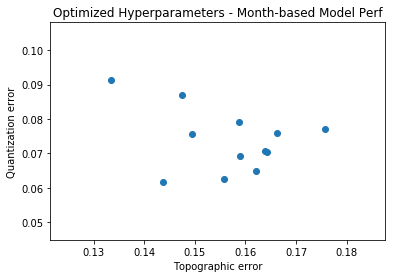

In [56]:
plt.scatter(e_top_opt_m, e_q_opt_m)
plt.title("Optimized Hyperparameters - Month-based Model Perf")
plt.xlabel("Topographic error")
plt.ylabel("Quantization error")
plt.savefig('Optimized_Model_Monthly_Top_Quant_Errors.png')
plt.show()

In [58]:
monthly_model_perf = []
for i, model_filepath in enumerate(models_pool_opt_m):
    monthly_model_perf.append({'model': model_filepath, 'topographical_error': e_top_opt_m[i], 'quantization_error': e_q_opt_m[i]})
    #print(model_filepath)
    #name.append(model_filepath[3:10])
    #err_top.append(e_top[i])
    #err_quant.append(e_q[i])

month_perf = pd.DataFrame(monthly_model_perf)
month_perf.sort_values(['topographical_error'], ascending=True)
#print(model_filepath,e_top[i],e_q[i])

,model,quantization_error,topographical_error
7,.\optimized_month_5.joblib,0.091407,0.133423
10,.\optimized_month_8.joblib,0.061564,0.143658
2,.\optimized_month_11.joblib,0.086847,0.147459
6,.\optimized_month_4.joblib,0.075683,0.149482
9,.\optimized_month_7.joblib,0.062668,0.155843
3,.\optimized_month_12.joblib,0.079049,0.158694
5,.\optimized_month_3.joblib,0.069300,0.158889
11,.\optimized_month_9.joblib,0.064769,0.162032
0,.\optimized_month_1.joblib,0.070629,0.163909
4,.\optimized_month_2.joblib,0.070287,0.164323


### Same as above but with log(MLD)

In [118]:
# Study the models trained and plot the errors obtained in order to select the best one
models_pool_opt_m_log = glob.glob("./optimized_month_pca_100_200_logMLD*")
errors=[]
for model_filepath in models_pool_opt_m_log:
    sm_opt_m_log = joblib.load(model_filepath)
    topographic_error = sm_opt_m_log.calculate_topographic_error()
    quantization_error = sm_opt_m_log.calculate_quantization_error()
    errors.append((topographic_error, quantization_error))
e_top_opt_m_log, e_q_opt_m_log = zip(*errors)

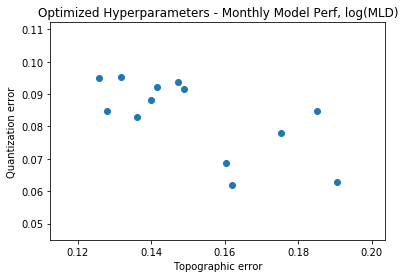

In [120]:
plt.scatter(e_top_opt_m_log, e_q_opt_m_log)
plt.title("Optimized Hyperparameters - Monthly Model Perf, log(MLD)")
plt.xlabel("Topographic error")
plt.ylabel("Quantization error")
plt.savefig('Optimized_Model_Monthly_Top_Quant_Errors_v2_logMLD.png')
plt.show()

In [123]:
monthly_model_perf_v2 = []
for i, model_filepath in enumerate(models_pool_opt_m_log):
    monthly_model_perf_v2.append({'model': model_filepath, 'topographical_error': e_top_opt_m_log[i], 'quantization_error': e_q_opt_m_log[i]})
    #print(model_filepath)
    #name.append(model_filepath[3:10])
    #err_top.append(e_top[i])
    #err_quant.append(e_q[i])

month_perf_v2 = pd.DataFrame(monthly_model_perf_v2)
month_perf_v2.sort_values(['topographical_error'], ascending=True)
#print(model_filepath,e_top[i],e_q[i])

,model,quantization_error,topographical_error
6,.\optimized_month_pca_100_200_logMLD_4.joblib,0.094939,0.125673
0,.\optimized_month_pca_100_200_logMLD_1.joblib,0.084701,0.127988
2,.\optimized_month_pca_100_200_logMLD_11.joblib,0.095294,0.131766
1,.\optimized_month_pca_100_200_logMLD_10.joblib,0.082815,0.136079
4,.\optimized_month_pca_100_200_logMLD_2.joblib,0.088188,0.139881
3,.\optimized_month_pca_100_200_logMLD_12.joblib,0.092240,0.141684
7,.\optimized_month_pca_100_200_logMLD_5.joblib,0.093782,0.147386
5,.\optimized_month_pca_100_200_logMLD_3.joblib,0.091599,0.149043
11,.\optimized_month_pca_100_200_logMLD_9.joblib,0.068772,0.160375
10,.\optimized_month_pca_100_200_logMLD_8.joblib,0.061829,0.161886


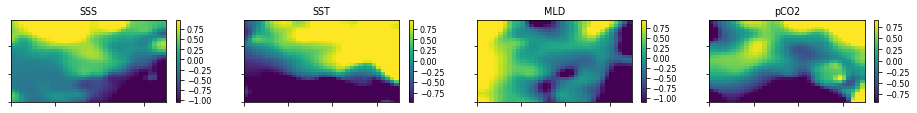

In [88]:
#top_model_n20_r20_f40_pca_rect.component_names = ['SSS','SST','MLD','pCO2']
from sompy.visualization.mapview import View2D
v2D = View2D(29,35, 'Optimized Component Heatmaps',text_size=8)  
v2D.show(optimized, col_sz=4, denormalize=True) #which_dim='all' default

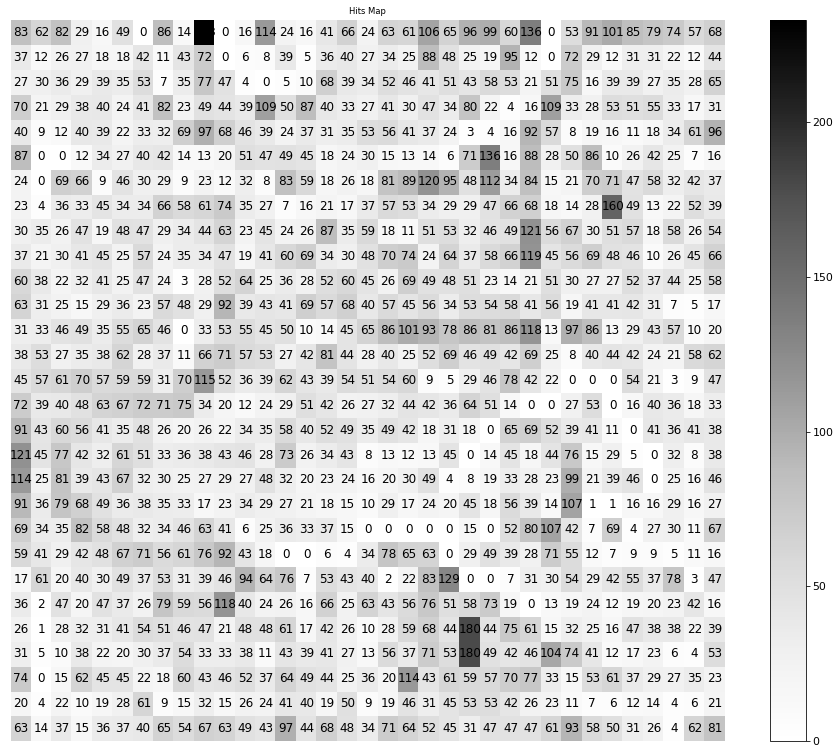

In [93]:
from sompy.visualization.bmuhits import BmuHitsView

vhts  = BmuHitsView(10,10,"Hits Map",text_size=11)
vhts.show(optimized, anotate=True, onlyzeros=False, labelsize=12, cmap="Greys", logaritmic=False)

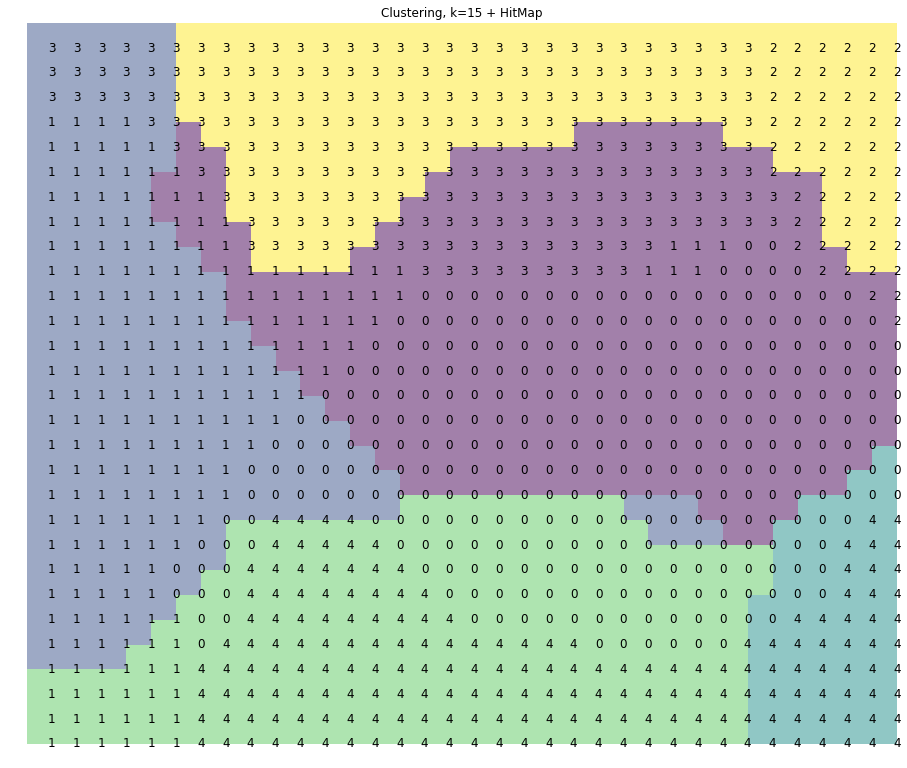

In [124]:
from sompy.visualization.hitmap import HitMapView
optimized.cluster(5)
hits  = HitMapView(10,10,"Clustering, k=15 + HitMap",text_size=7)
a=hits.show(optimized, labelsize=12)

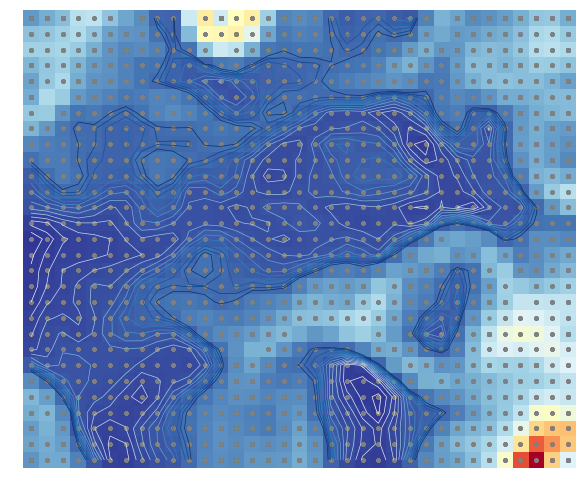

In [125]:
u = sompy.umatrix.UMatrixView(50, 50, 'umatrix', show_axis=True, text_size=8, show_text=True)

#This is the Umat value
UMAT  = u.build_u_matrix(optimized, distance=1, row_normalized=False)

#Here you have Umatrix plus its render
UMAT = u.show(optimized, distance2=1, row_normalized=False, show_data=True, contooor=True, blob=False)


In [63]:
for i in range(12):
    som = joblib.load('C:\\Users\goyetc\\SOMPY\\optimized_month_{}.joblib'.format(i+1))
    map_labels_k5 = som.cluster(n_clusters=5)
    data_labels_k5 = np.array([map_labels_k5[int(k)] for k in som._bmu[0]])
    map_labels_k10 = som.cluster(n_clusters=10)
    data_labels_k10 = np.array([map_labels_k10[int(k)] for k in som._bmu[0]])
    map_labels_k15 = som.cluster(n_clusters=15)
    data_labels_k15 = np.array([map_labels_k15[int(k)] for k in som._bmu[0]])
    
    Monthly['month-{}'.format(i+1)]['k=5'] = data_labels_k5
    Monthly['month-{}'.format(i+1)]['k=10'] = data_labels_k10
    Monthly['month-{}'.format(i+1)]['k=15'] = data_labels_k15
    
    Monthly['month-{}'.format(i+1)].to_csv('C:\\Users\\goyetc\\ocean-co2-absorption\\notebooks\\SOM\\SOM_Month_{}.csv'.format(i+1),
                  sep=',',
                  na_rep='NaN',
                  columns=[u'ylat', u'xlon', u'SSS', u'MLD', u'SST', u'pCO2', u'k=5', u'k=10', u'k=15'],
                  header=True,
                  index=True,
                  mode='w')

In [64]:
Monthly['month-2'].sample(10)

,ylat,xlon,SSS,MLD,SST,pCO2,k=5,k=10,k=15
18671,-13.5,346.5,36.294323,38.994919,25.494459,373.012956,2,0,7
39912,86.5,317.5,33.161171,79.945076,-1.801534,344.781629,0,1,13
13807,-30.5,14.5,34.762211,28.291983,20.710423,357.380964,2,0,7
7086,-51.5,324.5,33.574509,37.789185,7.450382,247.412134,4,7,3
17261,-18.5,255.5,36.219727,52.492203,24.801188,389.998410,2,0,7
29016,27.5,143.5,34.494514,107.625160,19.369177,304.221090,2,2,0
7218,-50.5,96.5,33.762821,53.730377,8.088168,304.816390,4,7,3
20935,-4.5,78.5,33.607609,50.950848,28.088097,360.537081,2,8,11
10829,-40.5,238.5,34.139713,31.738649,17.431696,395.392641,2,0,5
25016,10.5,176.5,34.009727,81.422745,26.756647,334.023750,2,8,11
